<a href="https://colab.research.google.com/github/sg879/IIBProject/blob/main/Test/Variational_Infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Variational Inference on the Test Data

## Importing Packages

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax
from functools import partial
import jax

In [6]:
from jax.config import config
config.update("jax_enable_x64", True)

## Load Test Data

In [7]:
testx = jnp.load('drive/MyDrive/Project/Test/Testx.npy').astype('f')
testy = jnp.load('drive/MyDrive/Project/Test/Testy.npy')
inw = jnp.load('drive/MyDrive/Project/Test/Inputwin.npy')
outw = jnp.load('drive/MyDrive/Project/Test/Outputwin.npy')

In [8]:
k = jnp.shape(testx)[0]-1
m = jnp.shape(testy)[0] - k - 1
binw = inw/k
timex = jnp.linspace(0.0, k*binw, k+1)
timey = jnp.linspace(0.0, (m+k)*binw, k+m+1)

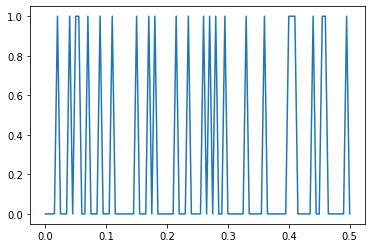

In [9]:
plt.plot(timex, testx)

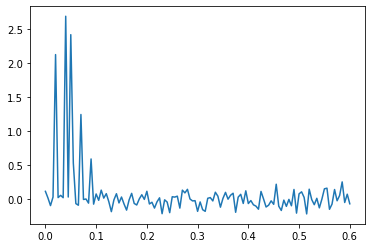

In [10]:
plt.plot(timey, testy)

## Function Definitions

### SE Prior


In [11]:
@jit
def squared_exp2(I, J, Ell, Sigma_f):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2*Ell**2.0))

In [12]:
vec_SE = jit(vmap(vmap(squared_exp2, in_axes=[None,0,None,None]),in_axes=[0,None,None,None]))

In [13]:
@jit
def root_squared_exp2(I, J, Ell, Sigma_f, Dt):
  return Sigma_f*(2/jnp.pi)**(0.25)*(Dt/Ell)**(0.5)*jnp.exp(-(I-J)**2/Ell**2)

In [14]:
vec_SE_root = jit(vmap(vmap(root_squared_exp2, in_axes=[None,0,None,None, None]),in_axes=[0,None,None,None, None]))

### Cholesky Check

In [15]:
@jit
def checknans(Symmetric_Matrix, Power):
  # Power MUST be input as a float
  M = jnp.shape(Symmetric_Matrix)[0]
  return Symmetric_Matrix, jnp.isnan(jnp.linalg.cholesky(Symmetric_Matrix +
                                                         (10**Power)*jnp.eye(M))).any().astype('f')

In [16]:
@jit
def choleskypwr(Symmetric_Matrix):
  Number_check = 60
  Power_list = -1*jnp.arange(Number_check + 1, dtype='f')
  _, Failure = lax.scan(checknans, Symmetric_Matrix, Power_list)
  return jnp.sum(Failure)

In [323]:
@jit
def broke_Chol(Symmetric_Matrix):
  F_size = jnp.shape(Symmetric_Matrix)[0]
  return jnp.linalg.cholesky(Symmetric_Matrix + 10.0**(-2.0)*jnp.eye(F_size))

In [18]:
@jit
def good_Chol(Symmetric_Matrix):
  return jnp.linalg.cholesky(Symmetric_Matrix)

In [19]:
def choleskyit(Symmetric_Matrix):
  Number_check = 60
  Power_list = -1*jnp.arange(Number_check+1)
  Base_list = 10*jnp.ones(Number_check)
  Lambdas = jnp.power(Base_list, Power_list)
  M = jnp.shape(Symmetric_Matrix)[0]
  Larr = jnp.linalg.cholesky(Symmetric_Matrix).flatten()
  Ind = 1

  while jnp.isnan(Larr).any():
    Larr = jnp.linalg.cholesky(Symmetric_Matrix + Lambdas.at[-Ind].get()*jnp.eye(M)).flatten()
    Ind += 1

  return Larr.reshape((M, M))

### Variational Bound (ELBO)

#### KL Divergence

In [22]:
@jit
def kl_div(L_matrix, Prior_cov_root,  Mu_prior, Param_vu):
  # Not including m/2 term as not being optimised over
  return jnp.sum(jnp.log(jnp.diag(L_matrix))) + 0.5*(jnp.linalg.norm(L_matrix)**2) + \
            0.5*(jnp.linalg.norm(jnp.linalg.lstsq(Prior_cov_root, Mu_prior)[0] - Param_vu)**2)

In [23]:
jax.devices()

In [24]:
jax.device_count()

1

#### Log Multivariate Gaussian PDF

In [25]:
@jit
def logmultivariate_normal(Input, Mean, Covariance_Matrix):
  # Excluding the sqrt(2*pi)**k to avoid overflow
  Diff = Input-Mean
  return -0.5*((Diff.T@jnp.linalg.lstsq(Covariance_Matrix, Diff)[0]) + jnp.log(jnp.linalg.det(Covariance_Matrix)))

In [26]:
#%timeit logmultivariate_normal(jnp.zeros((10000,)), jnp.zeros((10000,)), jnp.eye(10000))

In [27]:
vec_lognorm = jit(vmap(logmultivariate_normal, in_axes = [0, None, None]))

In [28]:
vec_lognorm(jnp.vstack((jnp.ones((10,)), jnp.zeros((10,)))), jnp.zeros((10,)), jnp.eye(10))

DeviceArray([-5., -0.], dtype=float64)

#### Expected Log Likelihood

In [29]:
@jit
def Log_Likely(Sampled_f, Truex, Truey, Sigma_n):

  K = jnp.shape(Truex)[0] - 1
  M = jnp.shape(Truey)[0] - K -1
  
  # Pad input and filter
  X_pad = jnp.hstack((Truex, jnp.zeros((M,))))
  F_pad = jnp.hstack((Sampled_f, jnp.zeros((K,))))

  # Compute the FFTs
  X_fft = jnp.fft.fft(X_pad)
  F_fft = jnp.fft.fft(F_pad)

  # Elementwise multiplication
  FFTmul = jnp.multiply(X_fft, F_fft)

  # Make mean
  Y_mean = jnp.real(jnp.fft.ifft(FFTmul))

  return jsc.stats.multivariate_normal.logpdf(Truey, Y_mean, Sigma_n*jnp.eye(M+K+1))

In [30]:
Log_Likely(jnp.ones((21,)), timex.flatten(), timey.flatten(), 0.05)

DeviceArray(-29424.24175997, dtype=float64)

In [31]:
vec_loglikely = jit(vmap(Log_Likely, in_axes = [1, None, None, None]))

In [329]:
#@partial(jit, static_argnums=(0,1))
def Exp_qf(Number_f, Num_Inducing, Subkey, Truex, Truey, Knn, Knm, Kmm, Inducing_Mean, Prior_cov_root, L_matrix, Sigma_n):

  
  # Sampling f
  A = Knm @ jnp.linalg.inv(Kmm)
  F_Mean = A @ Inducing_Mean
  F_Covariance = Knn + A @ (Prior_cov_root @ L_matrix @ L_matrix.T @ Prior_cov_root
                            - Kmm) @ A.T

  
  print("Inducing_Mean is: %s \n" % jnp.isnan(Inducing_Mean).any())
  print("A is: %s \n" % jnp.isnan(A).any())
  print("F_Mean is: %s \n" % jnp.isnan(F_Mean).any())
  print("F_Covariance is: %s \n" % jnp.isnan(F_Covariance).any())


  F_size = jnp.shape(F_Covariance)[0]
   # Cholesky f covariance
  F_Cholesky = lax.cond(jnp.isnan(jnp.linalg.cholesky(F_Covariance)).any(), broke_Chol, jnp.linalg.cholesky, F_Covariance)
  
  print("F_Cholesky is: %s \n" % jnp.isnan(F_Cholesky).any())

  #Sampled_f = random.multivariate_normal(Subkey, F_Mean, F_Covariance, shape = (Number_f,), method = 'svd').T
  Sampled_f = F_Mean.reshape((F_size, 1)) + F_Cholesky@random.normal(Subkey, (F_size, Number_f))

  return F_Covariance, jnp.mean(vec_loglikely(Sampled_f, Truex, Truey, Sigma_n), axis = None)

In [229]:
induc_p = timex[::10]

In [230]:
timef = timex[:21]

In [231]:
exar = [Exp_qf(i, 11, subkeys[-1], timex.flatten(), timey.flatten(), vec_SE(timef, timef, 0.05, 1.0), vec_SE(timef, induc_p, 0.05, 1.0), vec_SE(induc_p, induc_p, 0.05, 1.0), jnp.zeros((11,)), jnp.eye(11), jnp.eye(11), 0.05) for i in np.arange(1, 300000, 10000)]

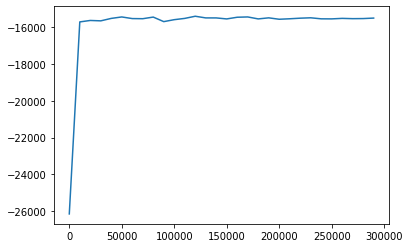

In [66]:
plt.plot(np.arange(1, 300000, 10000), exar)

In [ ]:
print(exar[0])

In [ ]:
#plt.plot(np.arange(1, 30000, 10000), exar)

#### ELBO

In [330]:
#@partial(jit, static_argnums=(0,1))
def ELBO(Number_f, Num_Inducing, Subkey, Inducing_Points, L_Arr, Param_vu, 
          Mu_prior, Ell, Sigma_f, Sigma_n, Truex, Truey, Dt, F_locs):
  L_matrix = L_fill(L_Arr, Num_Inducing)

  Knn = vec_SE(F_locs, F_locs, Ell, Sigma_f)
  Knm = vec_SE(F_locs, Inducing_Points, Ell, Sigma_f)
  Kmm = vec_SE(Inducing_Points, Inducing_Points, Ell, Sigma_f)
  Prior_cov_root = vec_SE_root(Inducing_Points, Inducing_Points, Ell, Sigma_f, Dt)

  print("Ell is: %s \n" % Ell)
  print("Prior_cov_root is: %s \n" % jnp.isnan(Prior_cov_root).any())

  Inducing_Mean = Prior_cov_root @ Param_vu

  print("Inducing_Mean is: %s \n" % jnp.isnan(Inducing_Mean).any())

  F_Covariance, One_Part = Exp_qf(Number_f, Num_Inducing, Subkey, Truex, Truey, Knn, Knm, Kmm,
                    Inducing_Mean, Prior_cov_root, L_matrix, Sigma_n)

  Two_Part = kl_div(L_matrix, Prior_cov_root,  Mu_prior, Param_vu)

  return F_Covariance, One_Part - Two_Part


In [332]:
TstChol, _ = ELBO(100000, num_inducing_points, subkeys[0], *arratst, testx, testy, 
          dt, f_loc)

Ell is: 0.1 

Prior_cov_root is: False 

Inducing_Mean is: False 

Inducing_Mean is: False 

A is: False 

F_Mean is: False 

F_Covariance is: False 

F_Cholesky is: True 



In [333]:
jnp.linalg.cholesky(TstChol)

DeviceArray([[nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
             [nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
             [nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
             [nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
             [nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
             [nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
             [nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
             [nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.

In [335]:
print(TstChol)

[[-16.59570892  16.20389271  13.05325748 -15.84228254 -13.93159336
   -7.93393853 -11.08199224   1.16732828  14.42449511  19.16506222
   15.71808209 -11.20823963   2.9454816  -16.00873462  -3.06903985
   15.62630096  10.064738    -2.63120679 -23.4015595   -7.85027495
    3.51402431]
 [ 16.20389271 -12.29933467  -8.47114871  15.84736711  14.75210571
    9.4675311   11.90210361   1.50713646 -10.3975806  -14.90383298
  -11.14894498  11.98403404  -0.51710892  16.24120414   3.66716018
  -11.40193082  -6.85444133   4.50655331  22.15165147   8.61412171
   -1.17557208]
 [ 13.05325748  -8.47114871 -13.99678315  10.75954991   5.11454925
    1.7461895    5.55808494  -4.40243651 -10.78639779 -11.52907727
  -14.85938224   4.69101937  -3.79232574   6.66777096   6.87376733
  -14.27145814  -8.91300309  -3.03054615  12.77861894   2.4730089
   -6.07375352]
 [-15.84228254  15.84736711  10.75954991 -15.70868976 -14.90620488
   -9.02287892 -11.51826207  -0.19751934  13.28484776  18.53121076
   13.71637383 

In [319]:
grad_elbo = grad(ELBO, argnums = jnp.arange(3, 10))

In [54]:
knn = vec_SE(f_loc, f_loc, init_l, init_sigma_f)
knm = vec_SE(f_loc, init_inducing_points, init_l, init_sigma_f)
kmm = vec_SE(init_inducing_points, init_inducing_points, init_l, init_sigma_f)
kmmroot = vec_SE_root(init_inducing_points, init_inducing_points, init_l, init_sigma_f, dt)

In [56]:
a = knm @ jnp.linalg.inv(kmm)

In [57]:
f_mean = a @ jnp.zeros(jnp.shape(a)[1])

In [97]:
%%capture
print(a @ (kmmroot @ L_fill(init_L, num_inducing_points) @ L_fill(init_L, num_inducing_points).T @ kmmroot
                            - kmm) @ a.T)

### Make Lower Triangle from L

In [105]:
@partial(jit, static_argnums=(1,))
def L_fill(L_arr, Num_Inducing):
  L_mat = jnp.zeros((Num_Inducing, Num_Inducing))
  mask = np.tri(Num_Inducing, dtype=bool)
  L_mat = L_mat.at[mask].set(L_arr)
  return L_mat

### Gradient Ascent

#### Backtracking Search

In [225]:
#@partial(jit, static_argnums = (0,1))
def Backcheck(Number_f, Num_Inducing, Subkey_elbo, Curr_IP, Curr_LA, 
              Curr_Vu, Curr_Mu, Curr_Ell, Curr_Sf, Curr_Sn, Truex, Truey, 
              Dt, F_locs, Grad_IP, Grad_LA, Grad_Vu, Grad_Mu, Grad_Ell, Grad_Sf,
              Grad_Sn, Step_size):
  
  Alpha = 0.3
  Beta = 0.1
  
  New_IP = Curr_IP + Alpha*Step_size*Grad_IP
  New_LA = Curr_LA + Alpha*Step_size*Grad_LA
  New_Vu = Curr_Vu + Alpha*Step_size*Grad_Vu
  New_Mu = Curr_Mu + Alpha*Step_size*Grad_Mu
  New_Ell = Curr_Ell + Alpha*Step_size*Grad_Ell
  New_Sf = Curr_Sf + Alpha*Step_size*Grad_Sf
  New_Sn = Curr_Sn + Alpha*Step_size*Grad_Sn

  """

  Left_side = ELBO(Number_f, Num_Inducing, Subkey_elbo, New_IP, New_LA, 
                   New_Vu, New_Mu, New_Ell, New_Sf, New_Sn, Truex, Truey, 
                   Dt, F_locs)
  
  All_Params = jnp.hstack((Grad_IP, Grad_LA, Grad_Vu, Grad_Mu, Grad_Ell, Grad_Sf,
                          Grad_Sn)).flatten()
  
  Right_side = ELBO(Number_f, Num_Inducing, Subkey_elbo, Curr_IP, Curr_LA, 
                    Curr_Vu, Curr_Mu, Curr_Ell, Curr_Sf, Curr_Sn, Truex, Truey, 
                    Dt, F_locs) + Alpha*Step_size*jnp.sum(jnp.square(All_Params))

  """
  
  return New_IP, New_LA, New_Vu, New_Mu, New_Ell, New_Sf, New_Sn 

In [260]:
updatedtst = Backcheck(100000, num_inducing_points, subkeys[0], *arratst, testx, testy, 
          dt, f_loc, *testgrad, 1.0)

In [258]:
print(updatedtst[2])

[ 451.47909227  619.62252514  741.54849053  741.46498466  871.37828919
 1131.36517222 1779.79346047 2211.64428612 2561.52473789 2247.77106082
 2134.4310641  1661.98944687 1705.85618187 1538.62959157 1797.75426052
 1873.32488855 2086.36505642 2197.25205673 2147.90826048 1677.24862069]


In [264]:
ELBO(100000, num_inducing_points, subkeys[0], *updatedtst, testx, testy, 
          dt, f_loc)

Ell is: -321431884.68769926 

Prior_cov_root is: True 

Inducing_Mean is: True 

A is: False 

F_Mean is: True 

F_Covariance is: True 



DeviceArray(nan, dtype=float64)

In [39]:
def Backtrack(Number_f, Num_Inducing, Subkey_elbo, Curr_IP, Curr_LA, 
                     Curr_Vu, Curr_Mu, Curr_Ell, Curr_Sf, Curr_Sn, Truex, Truey, 
                     Dt, F_locs):
  
  Step_size = 1.0

  while ELBO()


SyntaxError: ignored

In [188]:
@partial(jit, static_argnums = jnp.arange(15))
def Update_Curr(Curr_IP, Curr_LA, Curr_Vu, Curr_Mu, Curr_Ell, Curr_Sf, Curr_Sn, 
                Next_IP, Next_LA, Next_Vu, Next_Mu, Next_Ell, Next_Sf, Next_Sn, 
                Step_size):
  
  New_IP = Curr_IP + Step_size*Next_IP
  New_LA = Curr_LA + Step_size*Next_LA
  New_Vu = Curr_Vu + Step_size*Next_Vu
  New_Mu = Curr_Mu + Step_size*Next_Mu
  New_Ell = Curr_Ell + Step_size*Next_Ell
  New_Sf = Curr_Sf + Step_size*Next_Sf
  New_Sn = Curr_Sn + Step_size*Next_Sn

  return New_IP, New_LA, New_Vu, New_Mu, New_Ell, New_Sf, New_Sn 

In [189]:
Update_Curr(*arratst, *testgrad, 1.0)

ValueError: ignored

In [ ]:
def Grad_Ascent(Inducing_Points, L_Arr, Vu_Init, Mu_Init, Ell_Init, Sigma_f_Init, 
                Sigma_n_Init, Truex, Truey, F_locs, Dt, Epsilon, Subkeys):
  """
    Initial with vectors of:
       - Inducing Points (Initial[:m])
       - L Parameter (Initial[m:m+(m*(m+1)/2)])
       - Vu Parameter (Inital[m+(m*(m+1)/2):2*m+(m*(m+1)/2)])
       - Mu of Prior (Initial[2*m+(m*(m+1)/2): 3*m+(m*(m+1)/2)])
       - Ell of Prior (Initial[2*m+(m*(m+1)/2)])
       - Sigma_f of Prior (Initial[2*m+(m*(m+1)/2)+1])
       - Sigma_n of Prior/Model (Initial[2*m+(m*(m+1)/2)+2])
    
    Truex is the observed input data

    Truey is the observed output data

    Dt is the time resolution

    F_locs is the timestamps of the filter trying to infer    
  """
  Curr_IP = Inducing_Points
  Curr_LA = L_Arr
  Curr_Vu = Vu_Init
  Curr_Mu = Mu_Init
  Curr_Ell = Ell_Init
  Curr_Sf = Sigma_f_Init
  Curr_Sn = Sigma_n_Init
  Num_Inducing =  jnp.shape(Curr_IP)[0]
  Number_f = 200000
  Epsilon = 1.0
  Subkey_elbo = Subkeys[0]

  while jnp.linalg.norm(Curr_step) > Epsilon:
    Curr_step = grad_elbo(Number_f, Num_Inducing, Subkey_elbo, Curr_IP, Curr_LA, 
                     Curr_Vu, Curr_Mu, Curr_Ell, Curr_Sf, Curr_Sn, Truex, Truey, 
                     Dt, F_locs)
    Curr_ELBO = ELBO(Number_f, Num_Inducing, Subkey_elbo, Curr_IP, Curr_LA, 
                     Curr_Vu, Curr_Mu, Curr_Ell, Curr_Sf, Curr_Sn, Truex, Truey, 
                     Dt, F_locs)  







In [ ]:
def grad_asc_MargL(Epsilon, Initial):
  """
    Initial a vector of:
       - Inducing Points (Initial[:m])
       - L Parameter (Initial[m:m+(m*(m+1)/2)])
       - Vu Parameter (Inital[m+(m*(m+1)/2):2*m+(m*(m+1)/2)])
       - Mu of Prior (Initial[2*m+(m*(m+1)/2): 3*m+(m*(m+1)/2)])
       - Ell of Prior (Initial[3*m+(m*(m+1)/2)])
       - Sigma_f of Prior (Initial[3*m+(m*(m+1)/2)+1])
       - Sigma_n of Prior/Model (Initial[3*m+(m*(m+1)/2)+2])
    
    Truex is the observed input data

    Truey is the observed output data

    F_locs is the timestamps of the filter trying to infer
  """
  Max_Inducing = 10000
  Max_OutV_Len = jnp.rint(0.5*(Max_Inducing**2+5*Max_Inducing))
  Output_Vector = jnp.zeros(0.5*(Max_OutV_Len))

  SizeIn = jnp.shape(Initial)[0]
  Number_Inducing = jnp.rint(0.5*(-5+jnp.sqrt(25+8*SizeIn)))
  Gradient = jnp.ones(SizeIn)
  CurrIn = Initial

  while jnp.linalg.norm(Gradient) > Epsilon:
    Current_ELBO = ELBO(CurrIn)
    Step = -Gradient(CurrIn)

#### Data to test the functions individually

In [44]:
# Generate random key
key = random.PRNGKey(0)
key, *subkeys = random.split(key, 4)
subkeyl = subkeys[0]
subkeysig = subkeys[1]

# Generated test inducing points
num_ind = 10
tstloc = random.truncated_normal(key, 0.0, timey[-1]-timex[-1], (num_ind,))
tstloc = jnp.sort(tstloc)

# Generate covariance of inducing points with SE function (for ease, shouldn't ...
# do this for actual thing)
l_param = random.uniform(subkeyl)
sigma_param = random.uniform(subkeysig)
Gmat = vec_SE(tstloc, tstloc, 0.05, 0.1)

In [45]:
chol_chek = choleskypwr(Gmat)

att = jnp.linalg.cholesky(Gmat)

# Use cond statement to make more efficient
Lnew = jnp.linalg.cholesky(Gmat + chol_chek.any()*(10**(-60+jnp.sum(chol_chek)))*jnp.eye(num_ind))

# Generate arbitrary lower triangular matrix (not from PSD or symmetric)
tstmat = jnp.zeros((4,4))
tstmat = tstmat.at[jnp.tril_indices(4)].set(jnp.arange(1,11).astype('f'))

In [46]:
print(-60+jnp.sum(choleskypwr(Gmat)))

-18.0


In [47]:
print(broke_Chol(Gmat, 60))

TypeError: ignored

In [ ]:
print(checknans(Gmat, 10.0)[1])

In [ ]:
print(jnp.linalg.cholesky(Gmat+10**(-18.0)*np.eye(10)))

In [ ]:
np.isnan(np.linalg.cholesky(Gmat + (10**-50.0)*jnp.eye(10))).any().astype('f')

In [ ]:
print(jnp.linalg.cholesky(Gmat+ 10**(-2)*jnp.eye(10)))

## Running Scripts

### Setting up initial conditions

In [269]:
key = random.PRNGKey(0)
key, *subkeys = random.split(key, 4)

In [294]:
num_inducing_points = 20
init_inducing_points = jnp.linspace(0.0, timey[-1]-timex[-1], num_inducing_points)
init_L = jnp.eye(num_inducing_points).at[jnp.tri(num_inducing_points, dtype=bool)].get()
init_vu = random.normal(subkeys[-1], (num_inducing_points,))
init_mu = random.normal(subkeys[-2], (num_inducing_points,))
init_l = 0.1
init_sigma_f = 1.0
init_sigma_n = 0.1

In [277]:
testx = testx.flatten()
testy = testy.flatten()
dt = timey[1] - timey[0]
f_loc = jnp.arange(0.0, timey[-1]-timex[-1]+dt, dt) 

In [51]:
print(subkeys[0])

[3186719485 3840466878]


In [53]:
ELBO(Number_f, Num_Inducing, Subkey, Inducing_Points, L_matrix, Param_vu, 
          Mu_prior, Ell, Sigma_f, Sigma_n, Truex, Truey, Dt, F_locs):

SyntaxError: ignored

In [295]:
arratst = [init_inducing_points, init_L, init_vu, init_mu, init_l, init_sigma_f, init_sigma_n]

In [296]:
testgrad = grad_elbo(100000, num_inducing_points, subkeys[0], *arratst, testx, testy, dt, f_loc)

In [297]:
print(testgrad)

(DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan], dtype=float64), DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan, nan, 

In [173]:
print(*arratst)

[0.         0.00526316 0.01052632 0.01578947 0.02105263 0.02631579
 0.03157895 0.03684211 0.04210526 0.04736842 0.05263158 0.05789474
 0.06315789 0.06842105 0.07368421 0.07894737 0.08421053 0.08947368
 0.09473684 0.1       ] [1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] [ 0.93299772  1.49097413 -0.63761223 -0.54948096  1.15003635  1.0046516
  0.11826745 -1.42381648 -2.36721833  0.74104659  0.27467288 -1

In [168]:
print(jnp.shape(*arratst + *testgrad))

SyntaxError: ignored

In [77]:
print(L_fill(init_L, num_inducing_points))

ValueError: ignored

In [ ]:
grad_exq = grad(Exp_qf, argnums = jnp.arange(5, 12))

In [ ]:
trygrad = grad_exq(30000, num_inducing_points, subkeys[0], testx, testy, vec_SE(f_loc, f_loc, init_l, init_sigma_f), vec_SE(f_loc, init_inducing_points, init_l, init_sigma_f), 
               vec_SE(init_inducing_points, init_inducing_points, init_l, init_sigma_f), init_mu, vec_SE_root(init_inducing_points, init_inducing_points, init_l, init_sigma_f, dt),
               L_fill(init_L, num_inducing_points), init_sigma_n)

In [ ]:
jnp.shape(trygrad[0])

In [ ]:
print(jnp.shape(f_loc))

In [ ]:
print(L_fill(init_L, num_inducing_points))